In [1]:
import os.path

import pandas as pd
import numpy as np

In [2]:
DATA_BASE_PATH = "/Users/mirzasharmin/Downloads/Star copy 2"

In [3]:
from src.read_data import read_all_data

patient_dfs, sinus_dfs = read_all_data(DATA_BASE_PATH)

In [4]:
first_patient_key = list(patient_dfs.keys())[0]
first_sinus_keys = list(sinus_dfs.keys())[0]

In [5]:
from src.preprocess_data import downsample_data

downsampled_patient_dfs = downsample_data(patient_dfs, 400)
downsampled_sinus_dfs = downsample_data(sinus_dfs, 400)

In [7]:
from src.preprocess_data import filter_all_dataframes

filtered_patient_dfs = filter_all_dataframes(downsampled_patient_dfs, 50)
filtered_sinus_dfs = filter_all_dataframes(downsampled_sinus_dfs, 50)

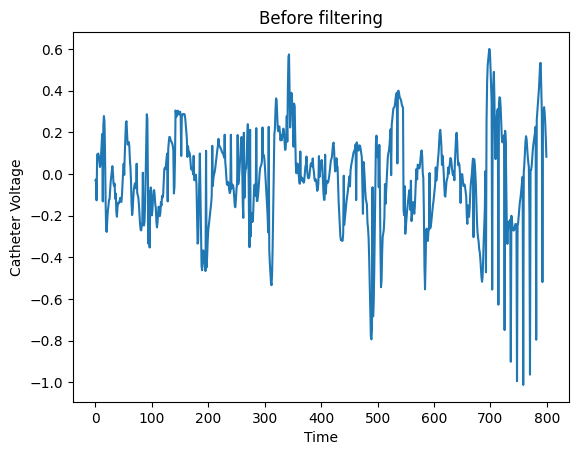

In [9]:
import matplotlib.pyplot as plt

plt.plot(downsampled_patient_dfs[first_patient_key]['c1'][:800])
plt.title('Before filtering')
plt.xlabel('Time')
plt.ylabel('Catheter Voltage')
plt.show()

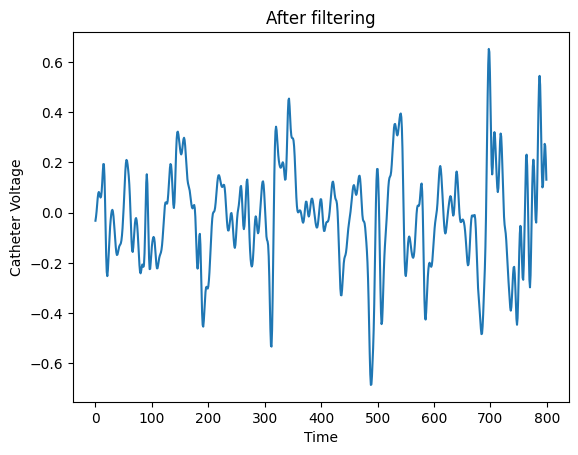

In [10]:
plt.plot(filtered_patient_dfs[first_patient_key]['c1'][:800])
plt.title('After filtering')
plt.xlabel('Time')
plt.ylabel('Catheter Voltage')
plt.show()

In [11]:
from src.preprocess_data import normalize_data

normalized_patient_dfs = normalize_data(filtered_patient_dfs)
normalized_sinus_dfs = normalize_data(filtered_sinus_dfs)

In [12]:
from src.preprocess_data import segment_data

patient_segmented_arrays = segment_data(normalized_patient_dfs, segment_duration_sec=4)
sinus_segmented_arrays = segment_data(normalized_sinus_dfs, segment_duration_sec=4)

Segmenting into 4-second segments (1600 samples each)...
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_30_06: 11 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_31_11: 10 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_32_46: 8 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_33_51: 10 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_34_38: 9 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_35_27: 10 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_36_35: 10 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_31_54: 8 segments created
 

In [13]:
sum([len(segments) for key, segments in patient_segmented_arrays.items()])

336

In [14]:
sum([len(segments) for key, segments in sinus_segmented_arrays.items()])

60

In [ ]:
from src.training import run_training_pipeline

model, history = run_training_pipeline(patient_segmented_arrays, sinus_segmented_arrays)

Starting EGM Classification Pipeline
=== Data Preparation ===
Sinus segments: 60
Patient segments: 336
Total segments: 396
Length check - Data: 396, Labels: 396

DataLoaders created:
Train batches: 9
Test batches: 4

Model created:
Parameters: 812,161

=== Training Setup ===
Device: cpu
Class weights - Sinus: 42, Patient: 235
Positive weight for BCEWithLogitsLoss: 5.595


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, 51)

# Loss plot

ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss')
ax1.plot(epochs, history['test_losses'], 'r-', label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot

ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy')
ax2.plot(epochs, history['test_accuracies'], 'r-', label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('figures/loss_curves.png')
plt.show()